In [1]:
using BSON
using Flux
using Plots

In [2]:
include("ActiveLearning.jl")
include("DataSets.jl")
using .ActiveLearning
using .DataSets

In [3]:
X_mnist_train, y_mnist_train, X_mnist_test, y_mnist_test = prepare_mnist(get_mnist("data/mnist"))
size(X_mnist_train), size(X_mnist_test)

((32, 32, 1, 60000), (32, 32, 1, 10000))

In [4]:
rounds_random, accuracies_random = simulate_al(
    random_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 40
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 50
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 60
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloade

(0:30, [0.6352, 0.6704, 0.7492, 0.7805, 0.8056, 0.8604, 0.8636, 0.8913, 0.9059, 0.9081  …  0.9416, 0.9546, 0.9535, 0.9562, 0.9587, 0.9444, 0.9558, 0.9577, 0.9608, 0.9634])

In [5]:
rounds_entropy, accuracies_entropy = simulate_al(
    entropy_sampling, oracle,
    BSON.load("lenet.bson")[:model],
    X_mnist_train, y_mnist_train,
    X_mnist_test, y_mnist_test)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 10
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 20
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 30
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 40
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 50
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloader.jl:82
┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 60
└ @ Flux.Data /home/podszond/.julia/packages/Flux/BPPNj/src/data/dataloade

(0:30, [0.6352, 0.7013, 0.7132, 0.7353, 0.7758, 0.7746, 0.8114, 0.8156, 0.8488, 0.8638  …  0.9684, 0.9663, 0.9735, 0.9719, 0.9738, 0.9713, 0.9724, 0.9724, 0.9711, 0.9736])

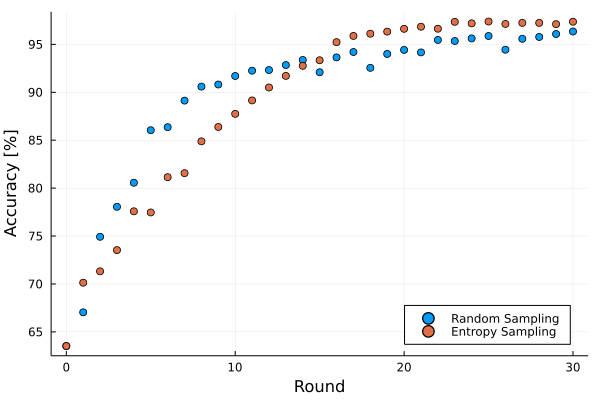

In [6]:
# TODO Run 30 runs to get error bars.
scatter(rounds_random, 100 .* accuracies_random, label="Random Sampling",
    legend_position=:bottomright, xlabel="Round", ylabel="Accuracy [%]")
scatter!(rounds_entropy, 100 .* accuracies_entropy, label="Entropy Sampling")